In [25]:
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from hazm import Normalizer, Lemmatizer, word_tokenize, stopwords_list
from collections import Counter
from wordcloud import WordCloud
from hazm import Normalizer, Lemmatizer, word_tokenize, stopwords_list
from sklearn.ensemble import IsolationForest, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import joblib, warnings
warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

df = r"D:\jeevi\DATASCIENCE\SEM 3\mini project\Instagram labeled comments.csv"
df=pd.read_csv(df)
OUTPUT_DIR = r"D:\New folder\models"
os.makedirs(OUTPUT_DIR, exist_ok=True)
TEST_SIZE, VAL_SIZE = 0.10, 0.10


In [26]:
# ==========================================================
# 🧠 Persian Text Preprocessing (Automatic Emoji Handling)
# ==========================================================

import re
import pandas as pd
import emoji
import demoji
from hazm import Normalizer, Lemmatizer, word_tokenize

# ----------------------------------------------------------
# 1️⃣ Initialize Hazm Tools
# ----------------------------------------------------------
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# ----------------------------------------------------------
# 2️⃣ Compile Regex Patterns
# ----------------------------------------------------------
RE_URL = re.compile(r"http\S+|www\.\S+")
RE_NONPERSIAN = re.compile(r"[^\u0600-\u06FFA-Za-z\s]")

# ----------------------------------------------------------
# 3️⃣ Automatic Emoji to Text Conversion
# ----------------------------------------------------------
# download emoji description map (run once)
demoji.download_codes()

def handle_emojis(text):
    """
    Convert emojis into their textual meaning automatically.
    Example: 😍 → :smiling_face_with_heart_eyes:
    """
    text = emoji.demojize(text, language='en')  # convert emojis to text
    text = demoji.replace(text, "")  # safely remove unknown emojis
    return text

# ----------------------------------------------------------
# 4️⃣ Clean Repetitions (Persian-specific)
# ----------------------------------------------------------
def clean_repetitions(text):
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)   # limit character repeats
    text = re.sub(r"(ه){2,}", r"هه", text)
    text = re.sub(r"(خ){2,}", r"خ", text)
    return text

# ----------------------------------------------------------
# 5️⃣ Main Preprocessing Function
# ----------------------------------------------------------
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def preprocess_text(text):
    """
    Cleans, normalizes, converts emojis, lemmatizes, and tokenizes Persian text.
    """
    if pd.isna(text):
        return ""
    text = str(text)

    # Step 1: Normalize Persian text
    text = normalizer.normalize(text)

    # Step 2: Handle emojis automatically
    text = handle_emojis(text)

    # Step 3: Clean repetitions
    text = clean_repetitions(text)

    # Step 4: Remove URLs, mentions, hashtags, English chars, numbers, etc.
    text = RE_URL.sub(" ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#([\u0600-\u06FF\w]+)", " ", text)  # ✅ fixes Persian hashtags
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[A-Za-z]", " ", text)
    text = RE_NONPERSIAN.sub(" ", text)


    # Step 5: Tokenize and lemmatize (no stopword removal)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if len(t) > 1]

    return " ".join(tokens).strip()

    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

# Safely extract text and preprocess
df["clean_text"] = df["comment"].apply(
    lambda x: preprocess_text(x["text"] if isinstance(x, dict) else str(x))
)

# Show first 5 preprocessed lines
print(df["clean_text"].head().to_string(index=False))




آقای رشیدپور من تا هفته بچه ام پسر بود#است لحظه...
                        چقدر این دزد باحال بود#است
سلام اگر ممکنه از کلمه سی تی اسکن تو برنامتون ا...
                شما پول اینترنت گوش رو هزینه بچ کن
آقای رشید پور به روستا ما بن گوشت یخ زده دادن ب...



=== Basic EDA (Raw Data) ===
Shape: (8512, 2)
Sample data:
                                              comment  sentiment
0  آقای رشیدپور من تا هفته NUM۲ بچه‌ام پسر بود و ...          1
1                چقدر این دزد باحال بود😁 😁 😁 😁 😁 😁 🌹          1
2  سلام اگر ممکنه از کلمه سی تی اسکن تو برنامتون ...         -1
Columns: ['comment', 'sentiment']

Missing values:
 comment      0
sentiment    0
dtype: int64

Duplicate rows: 10


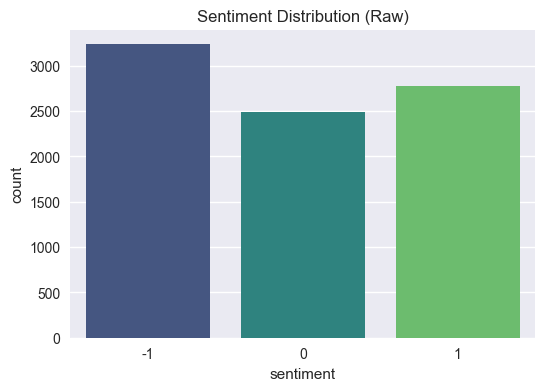

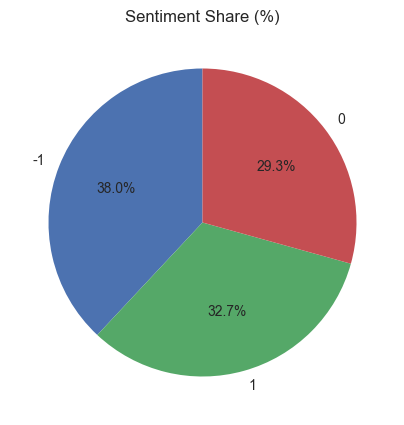


--- Text Length Summary ---
          char_len     word_len
count  8512.000000  8512.000000
mean     86.695136    17.109492
std     149.675180    29.000415
min       1.000000     1.000000
25%      21.000000     4.000000
50%      44.000000     9.000000
75%      96.000000    19.000000
max    2217.000000   430.000000


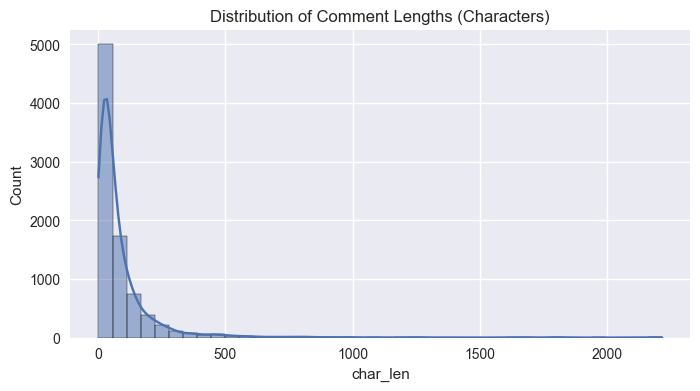

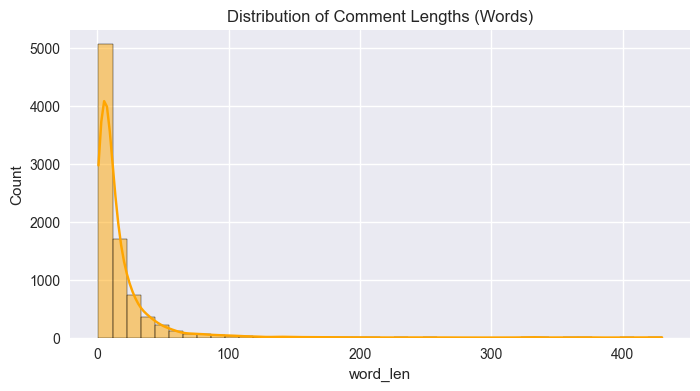

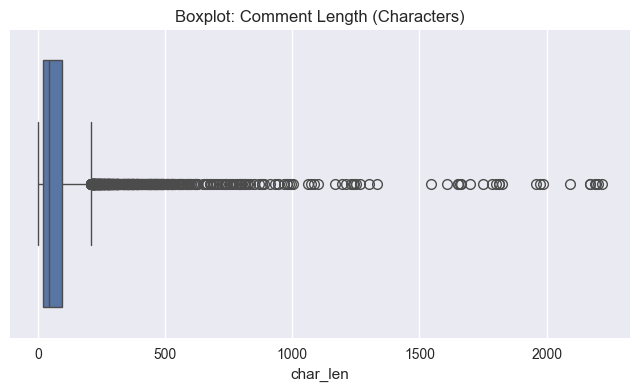

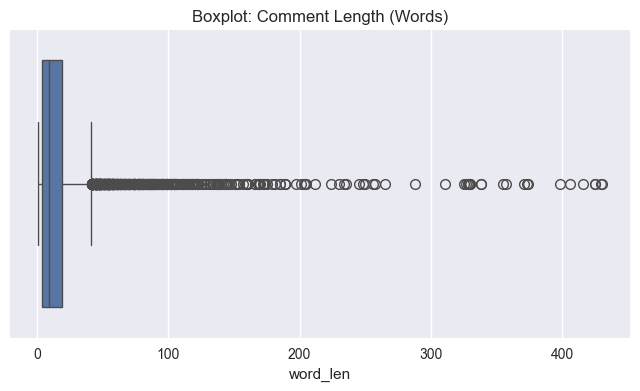

In [27]:
TEXT_COL = next((c for c in ["Comment","comment","text","comment_text","message"] if c in df.columns), None)
LABEL_COL = next((c for c in ["Label","label","sentiment","polarity","sentiment_label"] if c in df.columns), None)

if TEXT_COL is None or LABEL_COL is None:
    raise ValueError("Text/Label columns not found.")

df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True) 

print("\n=== Basic EDA (Raw Data) ===")
print("Shape:", df.shape)
print("Sample data:\n", df.head(3))
print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated(subset=[TEXT_COL]).sum())

plt.figure(figsize=(6,4))
sns.countplot(x=df[LABEL_COL], palette="viridis")
plt.title("Sentiment Distribution (Raw)")
plt.show()

plt.figure(figsize=(5,5))
df[LABEL_COL].value_counts().plot.pie(autopct="%1.1f%%", startangle=90)
plt.title("Sentiment Share (%)")
plt.ylabel("")
plt.show()

df["char_len"] = df[TEXT_COL].astype(str).str.len()
df["word_len"] = df[TEXT_COL].astype(str).str.split().apply(len)
print("\n--- Text Length Summary ---")
print(df[["char_len","word_len"]].describe())

plt.figure(figsize=(8,4))
sns.histplot(df["char_len"], bins=40, kde=True)
plt.title("Distribution of Comment Lengths (Characters)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df["word_len"], bins=40, kde=True, color="orange")
plt.title("Distribution of Comment Lengths (Words)")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df["char_len"])
plt.title("Boxplot: Comment Length (Characters)")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df["word_len"])
plt.title("Boxplot: Comment Length (Words)")
plt.show()



 Sample raw data:
                                              comment
0  آقای رشیدپور من تا هفته NUM۲ بچه‌ام پسر بود و ...
1                چقدر این دزد باحال بود😁 😁 😁 😁 😁 😁 🌹

Sample cleaned comments:
                                                clean
0  آقای رشیدپور من تا هفته بچه ام پسر بود#است لحظ...
1                         چقدر این دزد باحال بود#است
Classes: [-1  0  1]


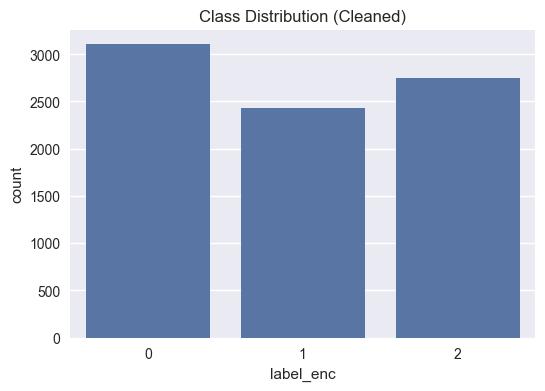

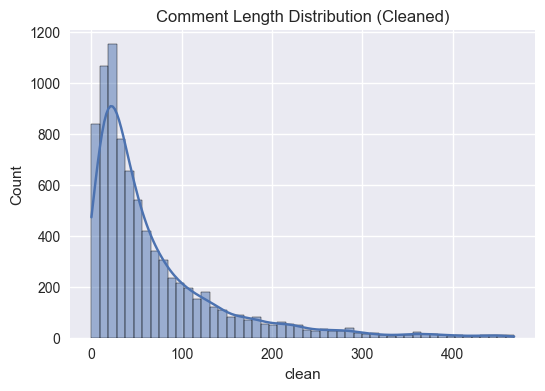

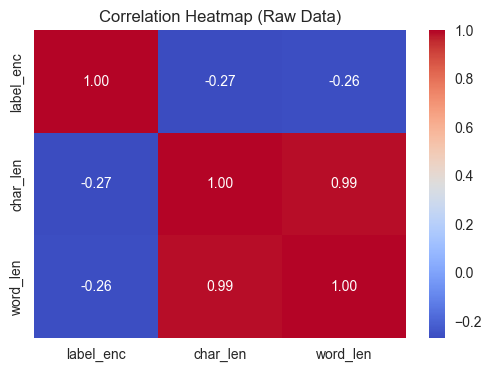

In [28]:
df = df.drop_duplicates(subset=[TEXT_COL])
df = df[df[TEXT_COL].astype(str).str.len() > 2]

df["clean"] = df[TEXT_COL].astype(str).apply(preprocess_text)
print("\n Sample raw data:\n",df[[TEXT_COL]].head(2))
print("\nSample cleaned comments:\n", df[["clean"]].head(2))
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_enc"] = le.fit_transform(df[LABEL_COL])
print("Classes:", le.classes_)

lengths = df["clean"].apply(len).values.reshape(-1,1)
iso = IsolationForest(contamination=0.02, random_state=SEED)
df["outlier"] = iso.fit_predict(lengths)
df = df[df["outlier"]==1].drop(columns=["outlier"])

plt.figure(figsize=(6,4))
sns.countplot(x=df["label_enc"])
plt.title("Class Distribution (Cleaned)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df["clean"].apply(len), bins=50, kde=True)
plt.title("Comment Length Distribution (Cleaned)")
plt.show()

corr = df[["label_enc", "char_len", "word_len"]].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Raw Data)")
plt.show()


Generating Persian WordClouds...


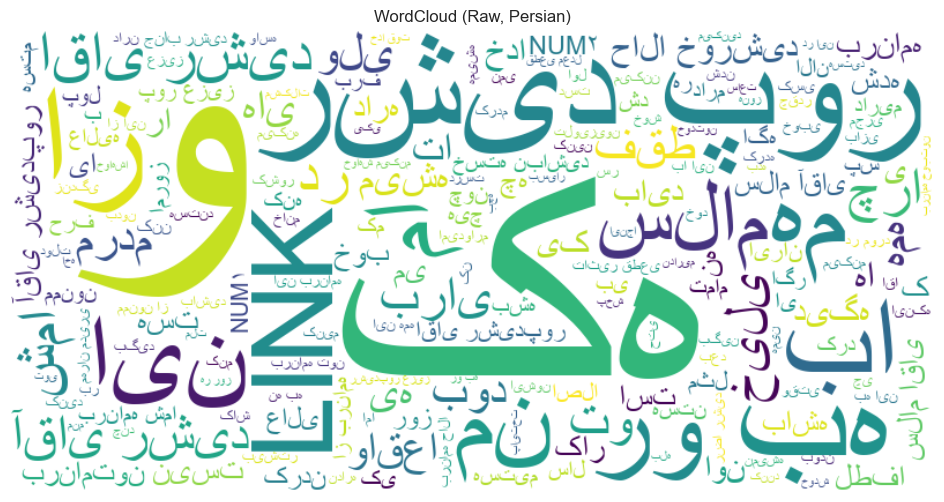

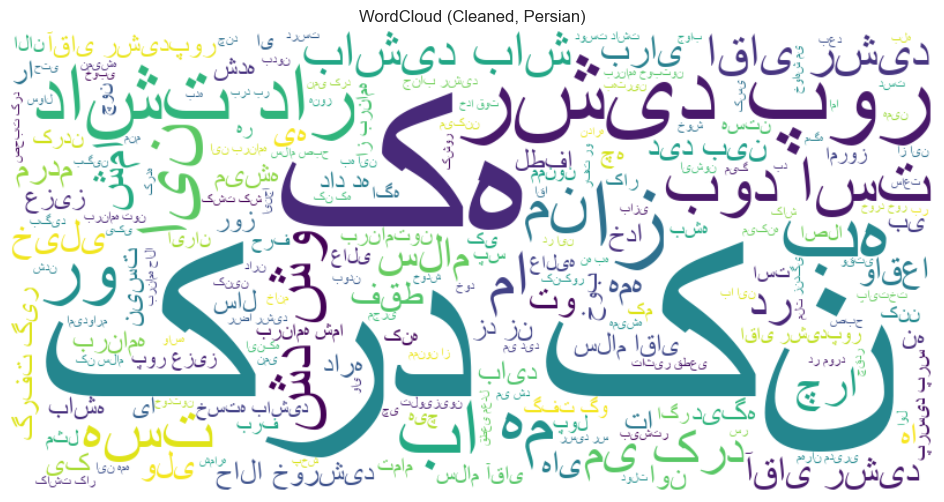

In [29]:
from wordcloud import WordCloud

persian_font = r"C:\Windows\Fonts\arial.ttf"
print("Generating Persian WordClouds...")

wc_raw = WordCloud(
    font_path=persian_font, width=800, height=400,
    background_color="white", max_words=200
).generate(" ".join(df[TEXT_COL].astype(str)))
plt.figure(figsize=(12,6))
plt.imshow(wc_raw, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud (Raw, Persian)")
plt.show()

wc_clean = WordCloud(
    font_path=persian_font, width=800, height=400,
    background_color="white", max_words=200
).generate(" ".join(df["clean"]))

plt.figure(figsize=(12,6))
plt.imshow(wc_clean, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud (Cleaned, Persian)")
plt.show()


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
plt.style.use("seaborn-v0_8")
SEED = 42
X_text = df.iloc[:, 0].astype(str)   
y = df["label_enc"]
X_text, y = shuffle(X_text, y, random_state=SEED)
X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    X_text, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_text, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)
vectorizer = TfidfVectorizer(
    max_features=10000,        # was 5000 → increase vocab coverage
    ngram_range=(1,3),         # capture bi/trigrams for contextual cues
    sublinear_tf=True,         # scale term frequency log-wise
    min_df=2,                  # ignore rare words
    max_df=0.9,                # ignore overly common words
)


X_train = vectorizer.fit_transform(X_train_text)
X_val = vectorizer.transform(X_val_text)
X_test = vectorizer.transform(X_test_text)



--- Logistic Regression Results ---
Train Acc: 0.6671837297483626
Val Acc: 0.6508447304907482
Test Acc: 0.6607717041800643
F1 (Test): 0.6619872199513357

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69       466
           1       0.57      0.69      0.62       365
           2       0.76      0.60      0.67       413

    accuracy                           0.66      1244
   macro avg       0.67      0.66      0.66      1244
weighted avg       0.67      0.66      0.66      1244



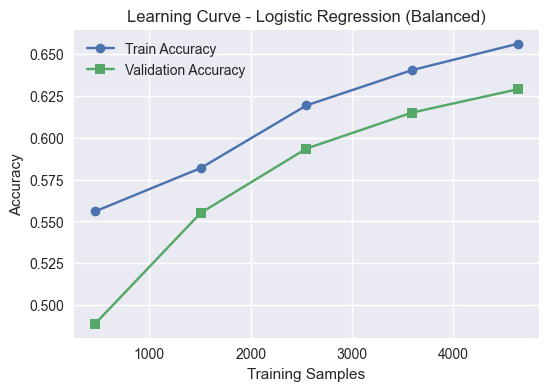

In [31]:
lr = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.3,
    C=0.2,
    class_weight='balanced',
    max_iter=1000,
    random_state=SEED
)

lr.fit(X_train, y_train)

train_pred = lr.predict(X_train)
val_pred = lr.predict(X_val)
test_pred = lr.predict(X_test)

print("\n--- Logistic Regression Results ---")
print("Train Acc:", accuracy_score(y_train, train_pred))
print("Val Acc:", accuracy_score(y_val, val_pred))
print("Test Acc:", accuracy_score(y_test, test_pred))
print("F1 (Test):", f1_score(y_test, test_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, test_pred))

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    lr, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 's-', label='Validation Accuracy')
plt.title("Learning Curve - Logistic Regression (Balanced)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


--- Random Forest ---
Test Accuracy: 0.6471061093247589
F1 Score: 0.644846570564959

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.77      0.69       466
           1       0.59      0.56      0.57       365
           2       0.74      0.59      0.65       413

    accuracy                           0.65      1244
   macro avg       0.65      0.64      0.64      1244
weighted avg       0.65      0.65      0.64      1244



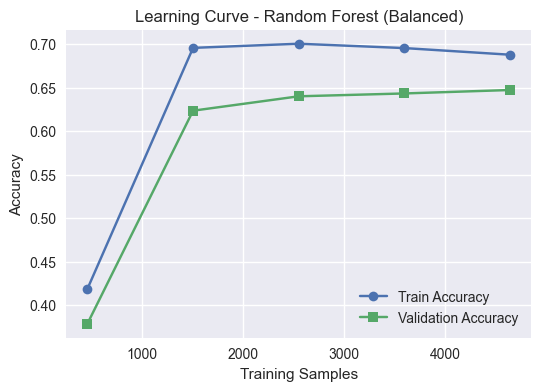

In [32]:
rf = RandomForestClassifier(
    n_estimators=300,           
    max_depth=22,               
    min_samples_split=4,        
    min_samples_leaf=4,         
    max_features='sqrt'
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("\n--- Random Forest ---")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    rf, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 's-', label='Validation Accuracy')
plt.title("Learning Curve - Random Forest (Balanced)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



--- XGBoost ---
Test Accuracy: 0.6278135048231511
F1 Score: 0.628724484077135

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.66       466
           1       0.53      0.70      0.60       365
           2       0.70      0.55      0.61       413

    accuracy                           0.63      1244
   macro avg       0.64      0.63      0.63      1244
weighted avg       0.64      0.63      0.63      1244



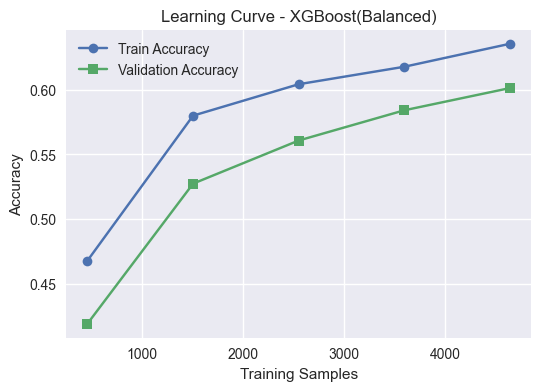

In [33]:
xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=6,
    reg_alpha=3,
    min_child_weight=15,
    gamma=1.2,
    eval_metric='mlogloss',
    random_state=SEED,
    use_label_encoder=False
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("\n--- XGBoost ---")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    xgb, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 's-', label='Validation Accuracy')
plt.title("Learning Curve - XGBoost(Balanced)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



--- Extra Trees ---
Test Accuracy: 0.6495176848874598
F1 Score: 0.6519753049189391

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69       466
           1       0.53      0.74      0.62       365
           2       0.74      0.57      0.64       413

    accuracy                           0.65      1244
   macro avg       0.67      0.65      0.65      1244
weighted avg       0.67      0.65      0.65      1244



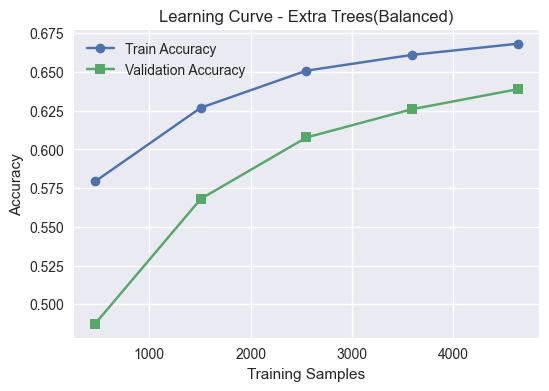

In [34]:
et = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=8,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)

et.fit(X_train, y_train)
y_pred = et.predict(X_test)
print("\n--- Extra Trees ---")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    et, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 's-', label='Validation Accuracy')
plt.title("Learning Curve - Extra Trees(Balanced)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



--- Voting Ensemble ---
Test Accuracy: 0.6495176848874598
F1 Score: 0.6503713041851757

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.69      0.68       466
           1       0.56      0.67      0.61       365
           2       0.73      0.58      0.65       413

    accuracy                           0.65      1244
   macro avg       0.66      0.65      0.65      1244
weighted avg       0.66      0.65      0.65      1244



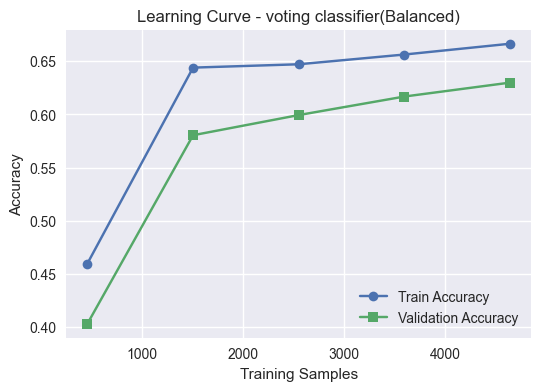

In [35]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('xgb', xgb),
        ('et', et)
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
voting_acc=accuracy_score(y_test, y_pred)
print("\n--- Voting Ensemble ---")
print("Test Accuracy:", voting_acc)
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    voting_clf, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 's-', label='Validation Accuracy')
plt.title("Learning Curve - voting classifier(Balanced)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [36]:
meta_learner = LogisticRegression(
    C=2.0,
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=3000,
    random_state=SEED
)

stacking_clf = StackingClassifier( estimators=[ ('lr', lr), ('rf', rf), ('xgb', xgb), ('et', et) ], 
                                  final_estimator=meta_learner, passthrough=True, cv=10, n_jobs=1 )
stacking_clf.fit(X_train, y_train) 
y_pred = stacking_clf.predict(X_test)
stacking_acc = accuracy_score(y_test, y_pred)
print("\n--- Stacking Ensemble ---")
print("Test Accuracy:", round(stacking_acc, 2))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



--- Stacking Ensemble ---
Test Accuracy: 0.73
F1 Score: 0.7281366253796814

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74       466
           1       0.66      0.75      0.70       365
           2       0.78      0.70      0.74       413

    accuracy                           0.73      1244
   macro avg       0.73      0.73      0.73      1244
weighted avg       0.73      0.73      0.73      1244



Logistic Regression: 0.6608
Random Forest: 0.6503
XGBoost: 0.6278
Extra Trees: 0.6495


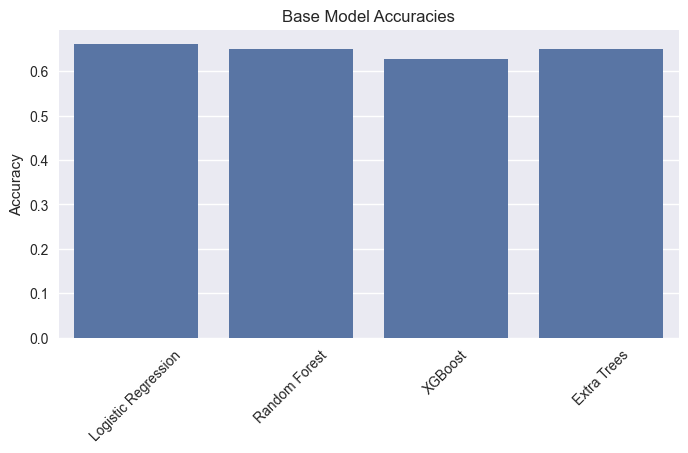

In [37]:
models = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'XGBoost': xgb,
    'Extra Trees': et
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

# Compare base model accuracies
plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Base Model Accuracies")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


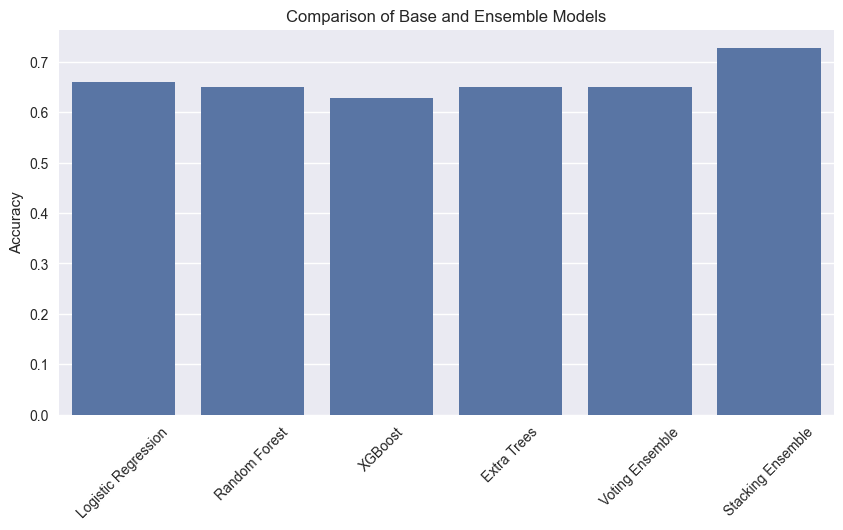


🏆 Best Performing Model: Stacking Ensemble with accuracy 0.73


In [38]:
# Combine all results
results['Voting Ensemble'] = voting_acc
results['Stacking Ensemble'] = stacking_acc

# Plot comparison
plt.figure(figsize=(10,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Comparison of Base and Ensemble Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

# Print best model
best_model = max(results, key=results.get)
print(f"\n🏆 Best Performing Model: {best_model} with accuracy {results[best_model]:.2f}")


🧩 Using model type: LogisticRegression
✅ SHAP LinearExplainer initialized successfully!


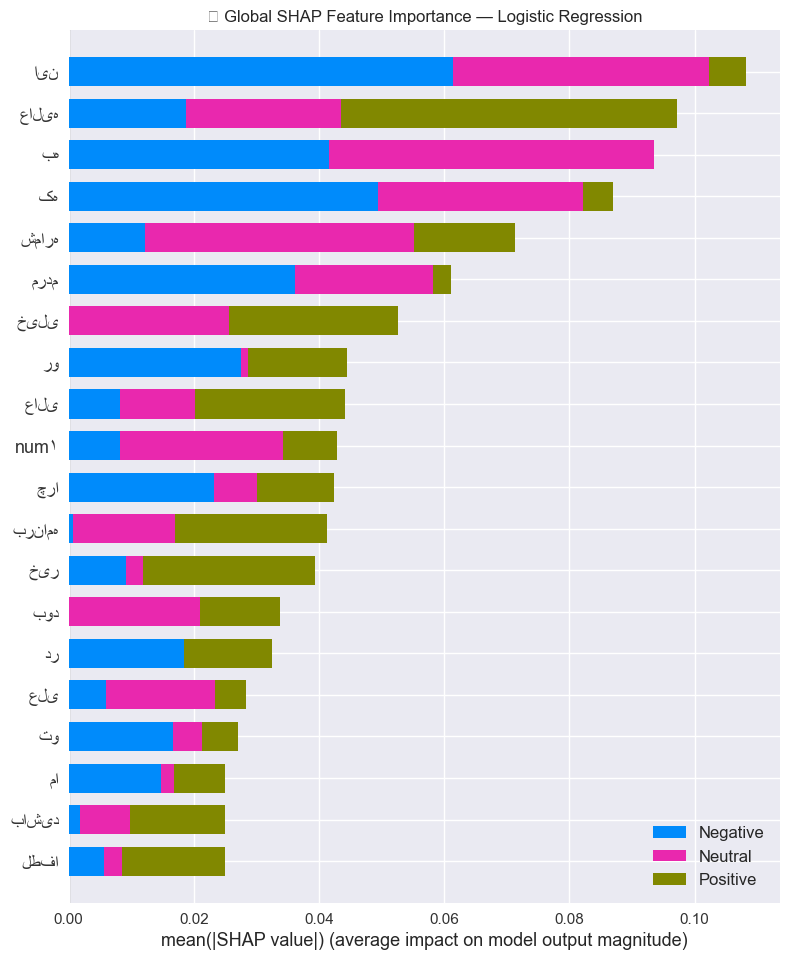


📝 Sample text for explanation:

روزتون مبارک آقای رشید پور گرامی🌹 🌹 🌹 🌹 🌹

🔎 Model prediction probabilities: [0.2506624  0.32579371 0.42354389]
🎯 Predicted Class: Positive (0.42 confidence)

🔴 Top Positive Words (push toward predicted sentiment):
           Word    Impact
0         مبارک  0.265896
1        روزتون  0.107764
2  روزتون مبارک  0.021053
3            رو  0.012288
4           چرا  0.008768
5           خیر  0.007495
6          لطفا  0.006939
7            تو  0.005765
8            کی  0.005094
9          کنید  0.004798

🔵 Top Negative Words (push away from predicted sentiment):
     Word    Impact
0   عالیه -0.027088
1    عالی -0.020030
2    خیلی -0.017690
3     بله -0.014671
4  برنامه -0.009721
5     گرم -0.009460
6     شما -0.008509
7     خوب -0.006149
8   باشید -0.005429
9   همیشه -0.005101


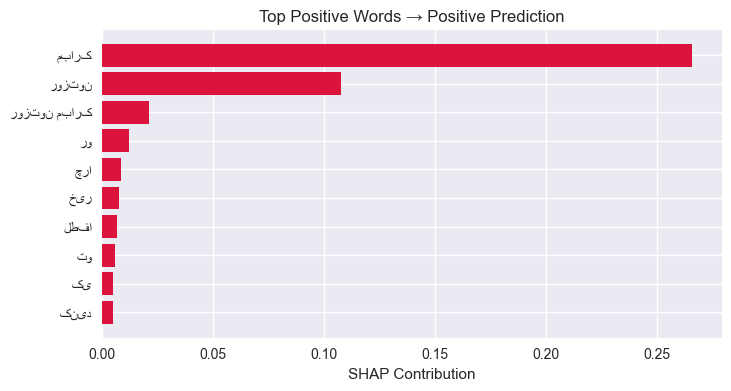

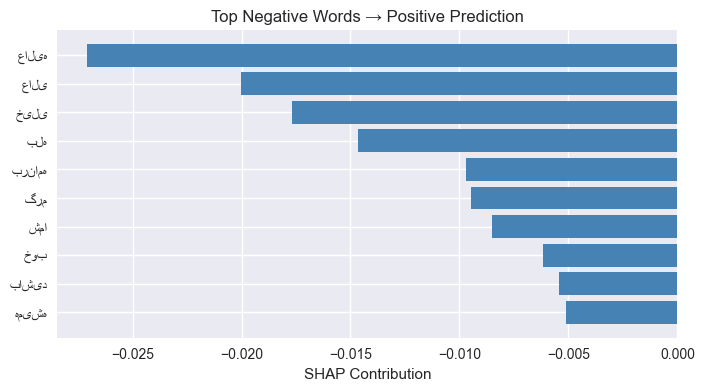

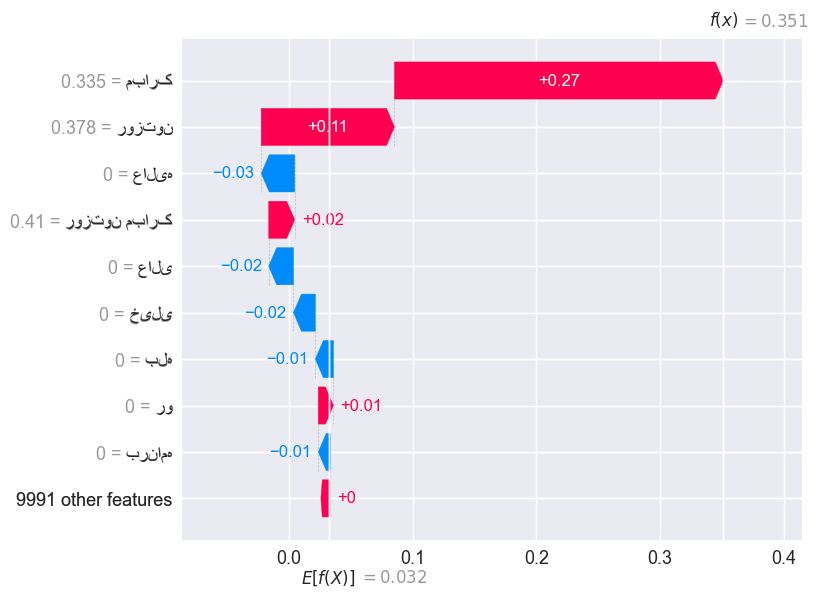


🧩 INTERPRETATION SUMMARY:
The model predicted sentiment as **Positive**.
- 🔴 Words (positive SHAP values) increase confidence toward Positive.
- 🔵 Words (negative SHAP values) reduce confidence for this sentiment.
- The longer the bar, the stronger the effect.
- These tokens are the main reasons why this text was classified as Positive.



In [39]:
# ===============================================================
# 🧠 Interpretable AI (Global + Local SHAP) for Logistic Regression
# ===============================================================

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse

# ---------------------------------------------------------------
# 1️⃣ Model + Vectorizer Setup
# ---------------------------------------------------------------
model = lr
vectorizer = vectorizer

print(f"🧩 Using model type: {type(model).__name__}")

# ---------------------------------------------------------------
# 2️⃣ Convert Sparse to Dense for SHAP
# ---------------------------------------------------------------
def to_dense(X):
    if scipy.sparse.issparse(X):
        return X.toarray()
    return X

X_train_dense = to_dense(X_train[:100])
X_test_dense = to_dense(X_test[:50])

# ---------------------------------------------------------------
# 3️⃣ SHAP Linear Explainer (Global)
# ---------------------------------------------------------------
explainer = shap.LinearExplainer(
    model,
    X_train_dense,
    feature_names=vectorizer.get_feature_names_out()
)
shap_values = explainer(X_test_dense)
print("✅ SHAP LinearExplainer initialized successfully!")

# ---------------------------------------------------------------
# 4️⃣ 🌍 Global SHAP Summary Plot (Multi-Class)
# ---------------------------------------------------------------
plt.figure(figsize=(8, 5))
shap.summary_plot(
    shap_values,
    features=X_test_dense,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=["Negative", "Neutral", "Positive"],
    show=False
)
plt.title("🌍 Global SHAP Feature Importance — Logistic Regression")
plt.show()

# ---------------------------------------------------------------
# 5️⃣ Local SHAP Explanation (Word-Level for One Sample)
# ---------------------------------------------------------------
sample_idx = 5  # change index for different samples
sample_text = X_test_text.iloc[sample_idx]
sample_vector = to_dense(X_test[sample_idx])

print("\n📝 Sample text for explanation:\n")
print(sample_text)

# Prediction probabilities
pred_probs = model.predict_proba(sample_vector)[0]
class_names = ["Negative", "Neutral", "Positive"]
pred_class = np.argmax(pred_probs)

print(f"\n🔎 Model prediction probabilities: {pred_probs}")
print(f"🎯 Predicted Class: {class_names[pred_class]} ({pred_probs[pred_class]:.2f} confidence)")

# ---------------------------------------------------------------
# 6️⃣ Extract SHAP Values for that Prediction
# ---------------------------------------------------------------
sample_shap = shap_values[sample_idx]
feature_names = np.array(vectorizer.get_feature_names_out())
shap_for_class = sample_shap.values[:, pred_class]

# Get top contributing words
n = 10
top_pos_idx = np.argsort(-shap_for_class)[:n]
top_neg_idx = np.argsort(shap_for_class)[:n]

# DataFrames for visualization
df_pos = pd.DataFrame({
    'Word': feature_names[top_pos_idx],
    'Impact': shap_for_class[top_pos_idx]
})
df_neg = pd.DataFrame({
    'Word': feature_names[top_neg_idx],
    'Impact': shap_for_class[top_neg_idx]
})

print("\n🔴 Top Positive Words (push toward predicted sentiment):")
print(df_pos)

print("\n🔵 Top Negative Words (push away from predicted sentiment):")
print(df_neg)

# ---------------------------------------------------------------
# 7️⃣ Bar Visualizations (Word Importance)
# ---------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.barh(df_pos['Word'], df_pos['Impact'], color='crimson')
plt.title(f"Top Positive Words → {class_names[pred_class]} Prediction")
plt.xlabel("SHAP Contribution")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8, 4))
plt.barh(df_neg['Word'], df_neg['Impact'], color='steelblue')
plt.title(f"Top Negative Words → {class_names[pred_class]} Prediction")
plt.xlabel("SHAP Contribution")
plt.gca().invert_yaxis()
plt.show()

# ---------------------------------------------------------------
# 8️⃣ Waterfall Plot (Detailed Explanation)
# ---------------------------------------------------------------
shap.initjs()
single_class_shap = shap.Explanation(
    values=sample_shap.values[:, pred_class],
    base_values=sample_shap.base_values[pred_class],
    data=sample_shap.data,
    feature_names=vectorizer.get_feature_names_out()
)
shap.plots.waterfall(single_class_shap, max_display=10)

# ---------------------------------------------------------------
# 9️⃣ Textual Interpretation Summary
# ---------------------------------------------------------------
print(f"""
🧩 INTERPRETATION SUMMARY:
The model predicted sentiment as **{class_names[pred_class]}**.
- 🔴 Words (positive SHAP values) increase confidence toward {class_names[pred_class]}.
- 🔵 Words (negative SHAP values) reduce confidence for this sentiment.
- The longer the bar, the stronger the effect.
- These tokens are the main reasons why this text was classified as {class_names[pred_class]}.
""")


In [40]:
# ===========================================================
# ✅ CONTINUATION: Model Saving, Loading & Inference Pipeline
# ===========================================================

import joblib
import os

# Create directory if it doesn't exist
MODEL_DIR = r"D:\New folder\models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save best model and vectorizer
joblib.dump(lr, os.path.join(MODEL_DIR, "best_model_persiann.pkl"))
joblib.dump(vectorizer, os.path.join(MODEL_DIR, "tfidf_vectorizer_persiann.pkl"))

print("\n✅ Models successfully saved!")






✅ Models successfully saved!
